In [1]:
import scanpy as sc 
import metashells as ms
from metashells.simulation import create_simulated_adata

In [37]:
adata_with_labels_file = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/scANVI_v2.h5ad'
adata = sc.read_h5ad(adata_with_labels_file)

/ocean/projects/cis240075p/asachan/.conda/envs/metasheller-py311/lib/python3.11/site-packages/anndata/_core/anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [38]:
adata

AnnData object with n_obs × n_vars = 87916 × 4000
    obs: 'sample_id', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'n_genes', 'sex', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'hb', 'ribo', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'C_scANVI_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_colo

In [39]:
adata.X = adata.layers['counts']
adata.X.min(), adata.X.max()

(np.float64(0.0), np.float64(1187.0))

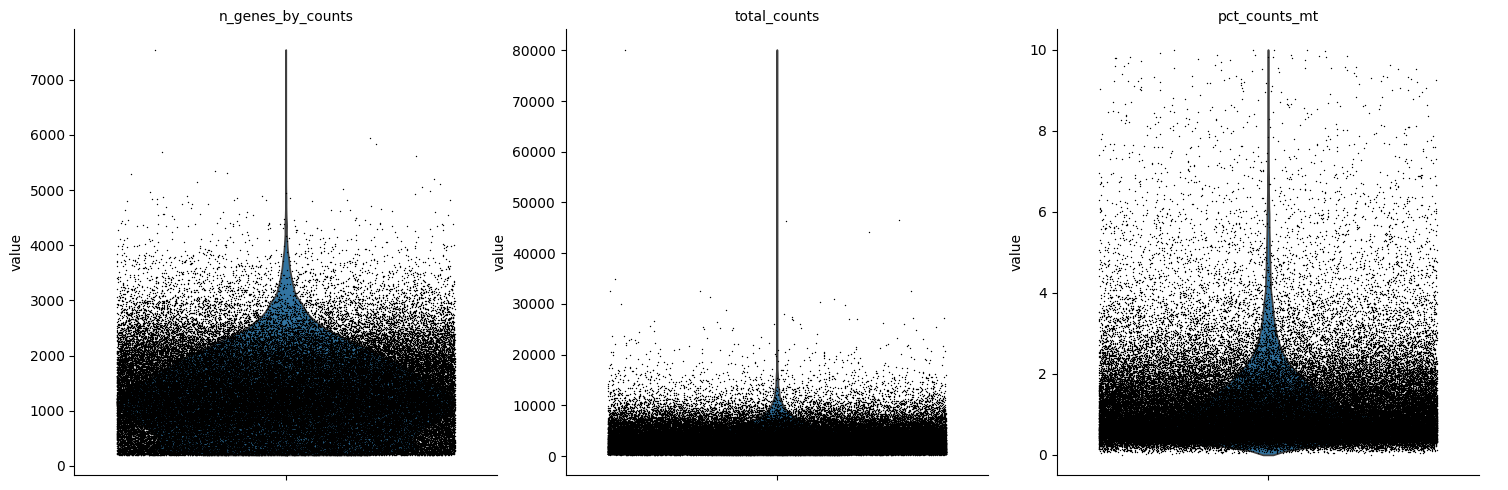

In [40]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)


In [41]:
# Filter out cells with high mitochondrial gene percentage
adata = adata[adata.obs['pct_counts_mt'] < 5]
adata

View of AnnData object with n_obs × n_vars = 86672 × 4000
    obs: 'sample_id', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'n_genes', 'sex', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'hb', 'ribo', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_colors', 'condi

### Pre-proc data

In [42]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

/ocean/projects/cis240075p/asachan/.conda/envs/metasheller-py311/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/ocean/projects/cis240075p/asachan/.conda/envs/metasheller-py311/lib/python3.11/site-packages/anndata/_core/anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [43]:
adata.X.min(), adata.X.max()

(np.float64(0.0), np.float64(8.489842479559137))

In [44]:
sc.tl.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_pcs=30)

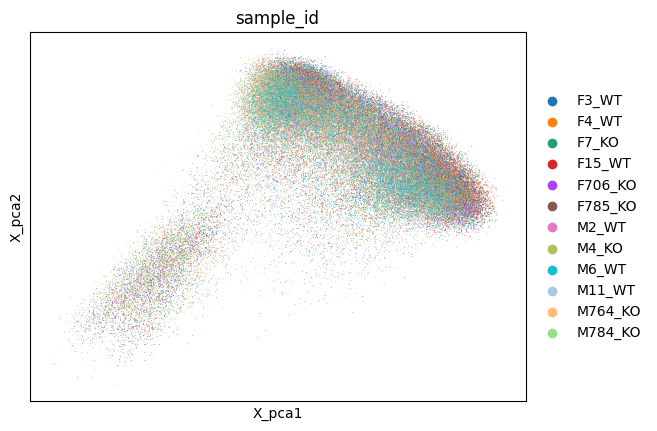

In [45]:
sc.pl.embedding(adata, basis='X_pca', color=['sample_id'])

#### Subset to cell type of interest

In [46]:
adata_sex = adata[adata.obs['sex'] == 'F']
# pool the fast2b and fast2x cell types
adata = adata_sex[adata_sex.obs['C_scANVI'].isin(['Fast IIB', 'Fast IIX'])]
adata

View of AnnData object with n_obs × n_vars = 34365 × 4000
    obs: 'sample_id', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'n_genes', 'sex', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'hb', 'ribo', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_

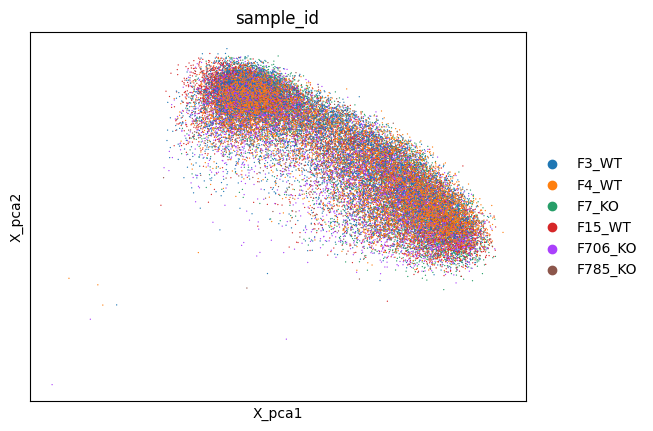

In [47]:
sc.pl.embedding(adata, basis='X_pca', color=['sample_id'])

In [48]:
adata.obs['condition'].value_counts()

condition
WT    17696
KO    16669
Name: count, dtype: int64

In [49]:
adata.obs['y'] = adata.obs['condition'].map({
    'WT': 0,
    'KO': 1
})
adata.obs['y'].value_counts()

/tmp/ipykernel_51829/3270180771.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['y'] = adata.obs['condition'].map({


y
0    17696
1    16669
Name: count, dtype: int64

# Run SeaCells

In [50]:
import os 

results_dir = './meta_cell_outputs'
os.makedirs(results_dir, exist_ok=True)

In [51]:
from metashells.seashells import SeaShells 

# to parallelize, simply submit multiple jobs running the following code

conch = SeaShells(
    adata_full = adata, 
    results_dir = results_dir,
    cells_per_metacell = 50, # recommended is 75 but can go as low as ~20 if really needed
    sample_col = 'sample_id'
)
conch.run()

# Prep adata from metacells

In [52]:
adata.X.min(), adata.X.max()

(np.float64(0.0), np.float64(7.81884592161892))

In [54]:
adata.layers['norm_counts'] = adata.X

In [55]:
gex_df = adata.to_df(layer='norm_counts')
gex_df.head(3)

,Xkr4,Gm1992,Rp1,Sox17,Rgs20,Alkal1,St18,Sntg1,2610203C22Rik,Cpa6,...,Tlr8,Tlr7,Frmpd4,Arhgap6,Gm15261,Gm15246,Mid1,Uty,Gm47283,Tmlhe
AAACCCAAGATTCGAA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.877991,0.0,0.0,2.239567,0.0,3.264529,0.0
AAACCCACACTCATAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.329268,0.0,0.0,0.000000,0.0,0.000000,0.0
AAACCCACAGCCTTCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.125857,0.0,0.0,0.000000,0.0,2.757484,0.0


In [56]:
from glob import glob
import pandas as pd

files = glob(results_dir + '/*.csv')
gex_df['SEACell'] = 'NA'
gex_df

for f in files:
    seacells = pd.read_csv(f, index_col=0)
    seacells = seacells['SEACell'].astype(str) + '_' + os.path.basename(f).split('.')[0]
    gex_df.loc[seacells.index, 'SEACell'] = seacells

gex_df = gex_df.groupby('SEACell').mean()

In [57]:
display(gex_df)

,Xkr4,Gm1992,Rp1,Sox17,Rgs20,Alkal1,St18,Sntg1,2610203C22Rik,Cpa6,...,Tlr8,Tlr7,Frmpd4,Arhgap6,Gm15261,Gm15246,Mid1,Uty,Gm47283,Tmlhe
SEACell,,,,,,,,,,,,,,,,,,,,,
0_F15_WT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.196932,0.000000,...,0.0,0.000000,0.000000,3.013165,0.875352,0.088499,1.086891,0.000000,2.026032,0.618058
0_F3_WT,0.001992,0.000000,0.000000,0.003537,0.008568,0.000000,0.000000,0.004651,0.061814,0.002548,...,0.0,0.001881,0.011752,2.567595,0.194246,0.016115,0.481456,0.002054,1.686465,0.502122
0_F4_WT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044277,0.000000,0.000000,...,0.0,0.000000,0.000000,2.576202,0.136104,0.000000,0.219530,0.000000,0.945232,0.389405
0_F706_KO,0.007984,0.000000,0.005107,0.003825,0.010785,0.000000,0.000000,0.011939,0.060656,0.004206,...,0.0,0.000000,0.012393,2.338628,0.203199,0.032496,0.457925,0.000000,0.935156,0.533004
0_F785_KO,0.000000,0.000000,0.000000,0.038831,0.000000,0.000000,0.000000,0.000000,0.123863,0.000000,...,0.0,0.000000,0.047767,3.485937,0.288983,0.000000,0.428887,0.000000,1.521389,0.834961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9_F4_WT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,2.671908,0.090434,0.000000,0.711650,0.000000,1.780995,0.630693
9_F706_KO,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,3.062724,0.256486,0.000000,0.808736,0.000000,0.765345,0.797565
9_F785_KO,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.144159,0.051520,...,0.0,0.000000,0.000000,2.857337,0.205770,0.101330,0.595489,0.000000,1.655014,0.693240


In [58]:
y = [0 if 'WT' in i else 1 for i in gex_df.index]

In [65]:
sample_id = [i.split('_')[-2] if len(i.split('_')) >= 2 else 'NA' for i in gex_df.index]

In [66]:
adata = sc.AnnData(
    X = gex_df.values,
    var = pd.DataFrame(index=gex_df.columns),
    obs = pd.DataFrame({'y': y, 'sample_id': sample_id}, index=gex_df.index)
)
adata

AnnData object with n_obs × n_vars = 214 × 4000
    obs: 'y', 'sample_id'

In [67]:
adata.write_h5ad(f'/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/seacells_F_FastIIB.h5ad')

## Visualize the metacells

In [68]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, inplace=True)

sc.tl.pca(adata, use_highly_variable=True)
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.umap(adata)
     

/ocean/projects/cis240075p/asachan/.conda/envs/metasheller-py311/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:226: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


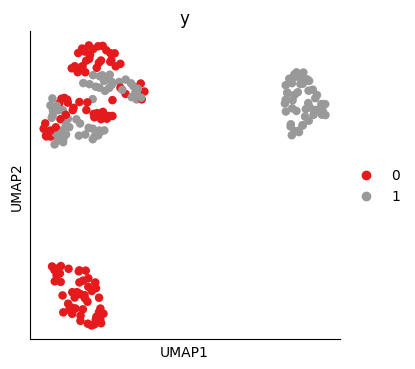

In [69]:
# Convert the 'y' column to the pandas 'category' dtype
adata.obs['y'] = adata.obs['y'].astype('category')
adata.obs['sample_id'] = adata.obs['sample_id'].astype('category')
# The plotting command will now work correctly
sc.pl.umap(adata, color='y', palette='Set1', s=150)

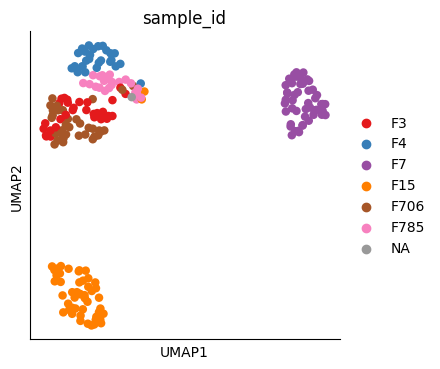

In [70]:
sc.pl.umap(adata, color='sample_id', palette='Set1', s=150)